In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from circle_generator import Circles
from loss import SegmentationLoss, ImageLoss
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tqdm
import matplotlib.pyplot as plt
import copy
import random
from img_segm_img_model import ImageSegmentationImageModel
from eunet import EUnet

In [2]:
def generate_data(predata, batch_sizes):
    np.random.seed(42)
    data = {}
    splits = ['train', 'val', 'test']
    for batch_size, split in zip(batch_sizes, splits):
        images, segmentation = predata.get_train_batch(batch_size)
        images = Variable(torch.from_numpy(images).float().cuda(0), requires_grad=False)
        segmentation = Variable(torch.from_numpy(segmentation).cuda(0), requires_grad=False)
        data[split] = (images, segmentation)
    return data

In [3]:
def train(data, net, number_without_segmentation, num_epoch, img_loss, segm_loss):
    train_loss_history = []
    val_loss_history = []
    
    last_update = 0
    best_val_score = None
    best_model_params = None
    
    optimizer = optim.Adam(net.parameters())
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        net.train(True)
        optimizer.zero_grad()
        generated_images, generated_segmentation = net.forward(data['train'][0])
        
        if number_without_segmentation > 0:
            train_loss = segm_loss(generated_segmentation[:-number_without_segmentation], 
                                   data['train'][1][:-number_without_segmentation])
        else:
            train_loss = segm_loss(generated_segmentation, data['train'][1])
            
        train_loss += 1000*img_loss(generated_images, data['train'][0])
        train_loss_history.append(train_loss.data[0])
        
        train_loss.backward()
        optimizer.step()
        
        net.train(False)
        generated_val_images, generated_val_segmentation = net.forward(data['val'][0])
        val_loss = segm_loss(generated_val_segmentation, data['val'][1])
        val_loss += 1000*img_loss(generated_val_images, data['val'][0])
        val_loss_history.append(val_loss.data[0])
        
        if best_val_score is None or best_val_score > val_loss_history[-1]:
            best_val_score = val_loss_history[-1]
            best_model_params = copy.deepcopy(net.state_dict())
            last_update = 0
        else:
            last_update += 1

        
    #net.load_state_dict(best_model_params)
        #print('---- epoch {} -----'.format(epoch))
        #print('loss on train = {}'.format(train_loss_history[-1]))
        #print('loss on validation = {}'.format(val_loss_history[-1]))
        
    return train_loss_history, val_loss_history, best_model_params

In [4]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

In [5]:
def test(net, data, segm_loss, img_loss):
    generated_images, generated_segmentation = net.forward(data['test'][0])

    segm_test_loss = segm_loss(generated_segmentation, data['test'][1]).data[0]
    l2_test_loss = img_loss(generated_images, data['test'][0]).data[0]
    #print('segmetation loss on test = {}'.format(segm_test_loss))
    #print('l2 loss on test = {}'.format(l2_test_loss))

    generated_images = generated_images.cpu().data.numpy()
    generated_segmentation = generated_segmentation.cpu().data.numpy()
    gt_images = data['test'][0].cpu().data.numpy()
    gt_segmentation = data['test'][1].cpu().data.numpy()

    #show_image_segm(generated_images, generated_segmentation, gt_images, gt_segmentation)
    return segm_test_loss, l2_test_loss, generated_images, generated_segmentation

### Experiments

we generated 192 training samples. We will use 64 of them with segmentation adding others to see whether the performance of network with be better adding unlabelled data. 

In [6]:
### generate data
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
data = generate_data(predata, [192, 32, 16])

In [7]:
### initialize network and save parameters
net = ImageSegmentationImageModel(input_dim=1, num_classes=3, batch_norm=True).cuda(0)
starting_parameters = copy.deepcopy(net.state_dict())
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

In [8]:
def experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 
                                    labelled_data_size, unlabelled_data_size, num_epoch=20000):

    net.load_state_dict(starting_parameters)

    data_current = copy.deepcopy(data)
    data_current['train'] = (data['train'][0][:labelled_data_size + unlabelled_data_size], 
                             data['train'][1][:labelled_data_size + unlabelled_data_size])

    train_loss_history, val_loss_history, early_stopping_params = train(data_current, net, unlabelled_data_size, 
                                                                        num_epoch, img_loss, segm_loss)

    plt.semilogy(train_loss_history, label='train, unlabeled data = {}'.format(unlabelled_data_size))
    plt.semilogy(val_loss_history, label='val, unlabeled data = {}'.format(unlabelled_data_size))
    
    plt.title('Training/validation loss with unlabelled data = {}'.format(unlabelled_data_size))
    plt.legend()
    plt.show()
    
    net.load_state_dict(early_stopping_params)

    test_results = test(net, data, segm_loss, img_loss)
    
    return test_results
    

In [9]:
history_segm_test, history_l2_test = [], []
segmentation_test, reconstruction_test = [], []

100%|██████████| 30000/30000 [53:33<00:00,  9.33it/s]


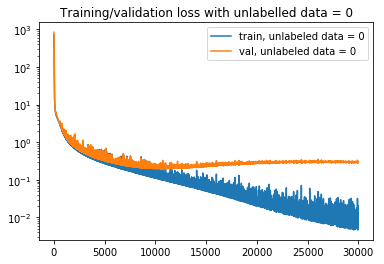

In [10]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 0, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

100%|██████████| 30000/30000 [1:15:23<00:00,  6.63it/s]


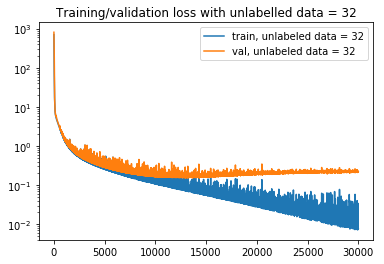

In [11]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 32, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

100%|██████████| 30000/30000 [1:33:27<00:00,  5.35it/s]


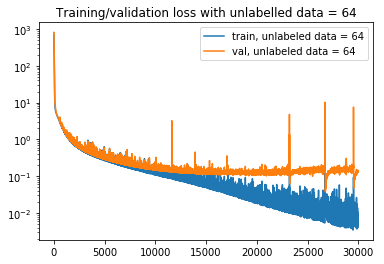

In [12]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 64, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

100%|██████████| 30000/30000 [2:15:38<00:00,  3.69it/s]  


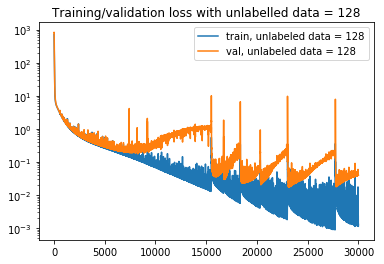

In [13]:
test_results = experiment_size_unlabelled_data(net, data, starting_parameters, img_loss, segm_loss, 64, 128, 30000)
history_segm_test.append(test_results[0])
history_l2_test.append(test_results[1])
reconstruction_test.append(test_results[2])
segmentation_test.append(test_results[3])

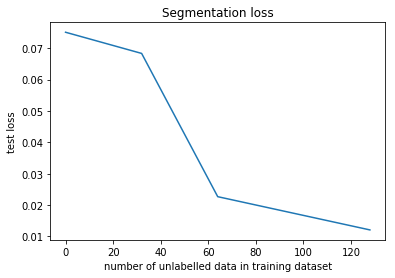

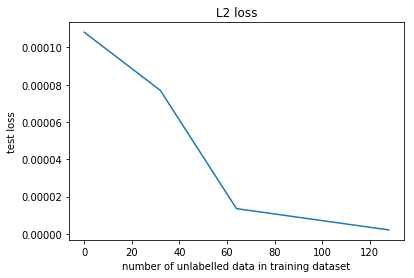

In [15]:
plt.title('Segmentation loss')
plt.xlabel('number of unlabelled data in training dataset')
plt.ylabel('test loss')
plt.plot([0, 32, 64, 128], history_segm_test)
plt.show()

plt.title('L2 loss')
plt.xlabel('number of unlabelled data in training dataset')
plt.ylabel('test loss')
plt.plot([0, 32, 64, 128], history_l2_test)
plt.show()

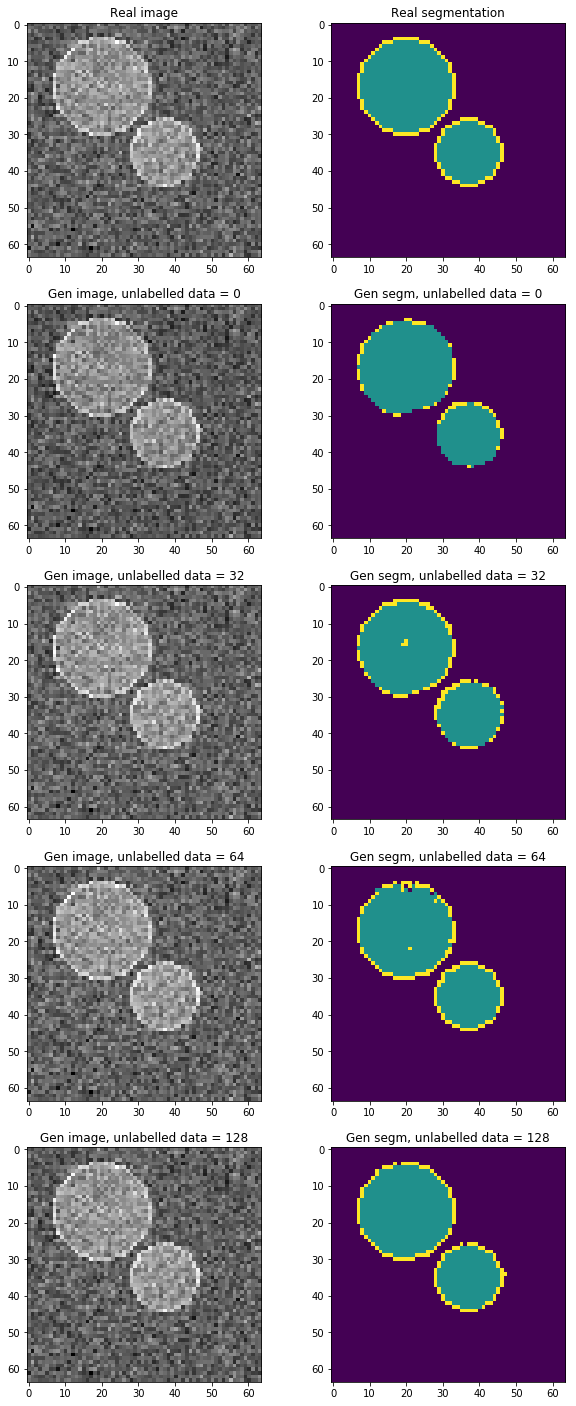

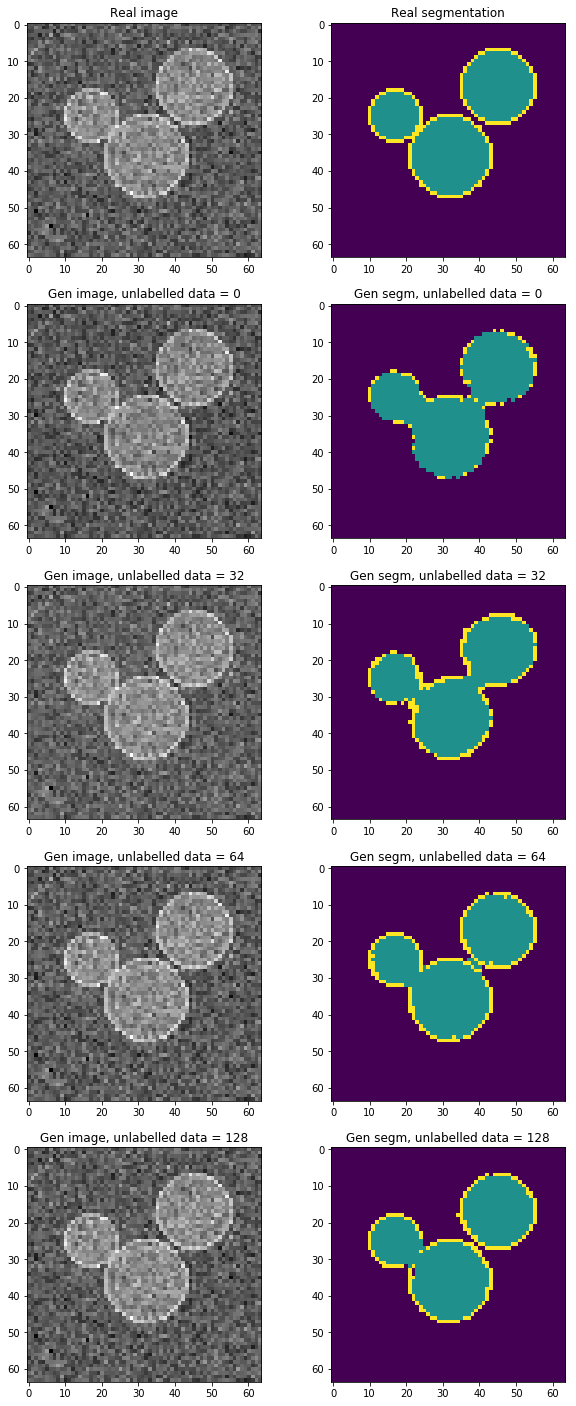

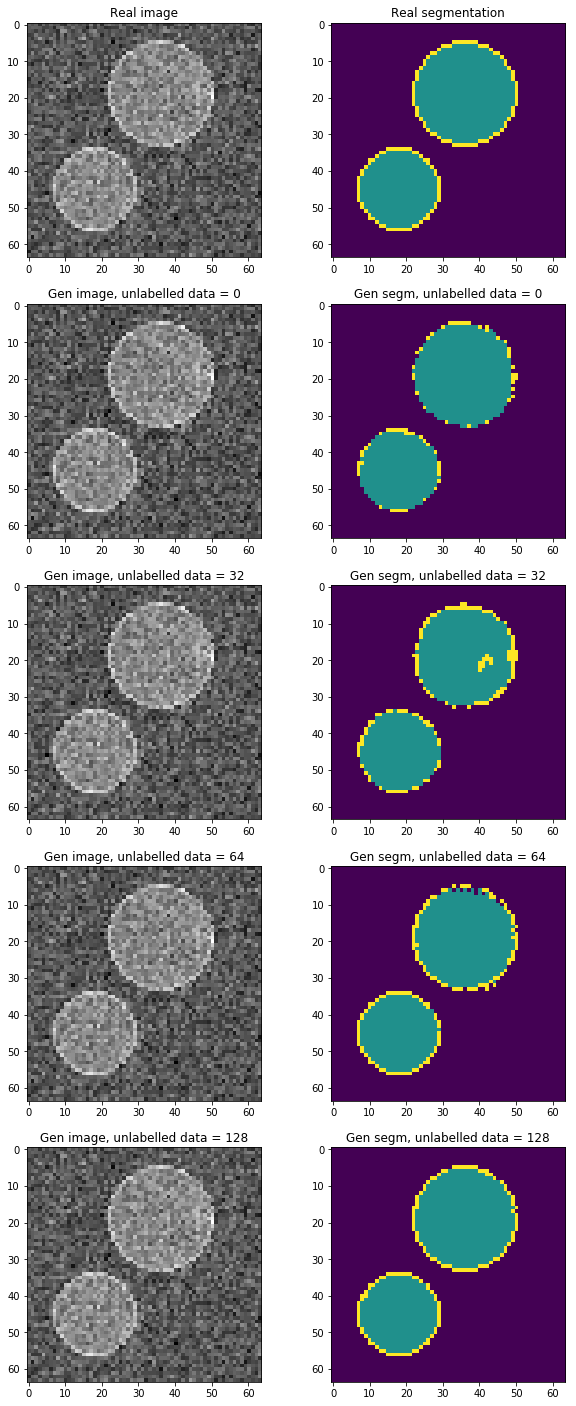

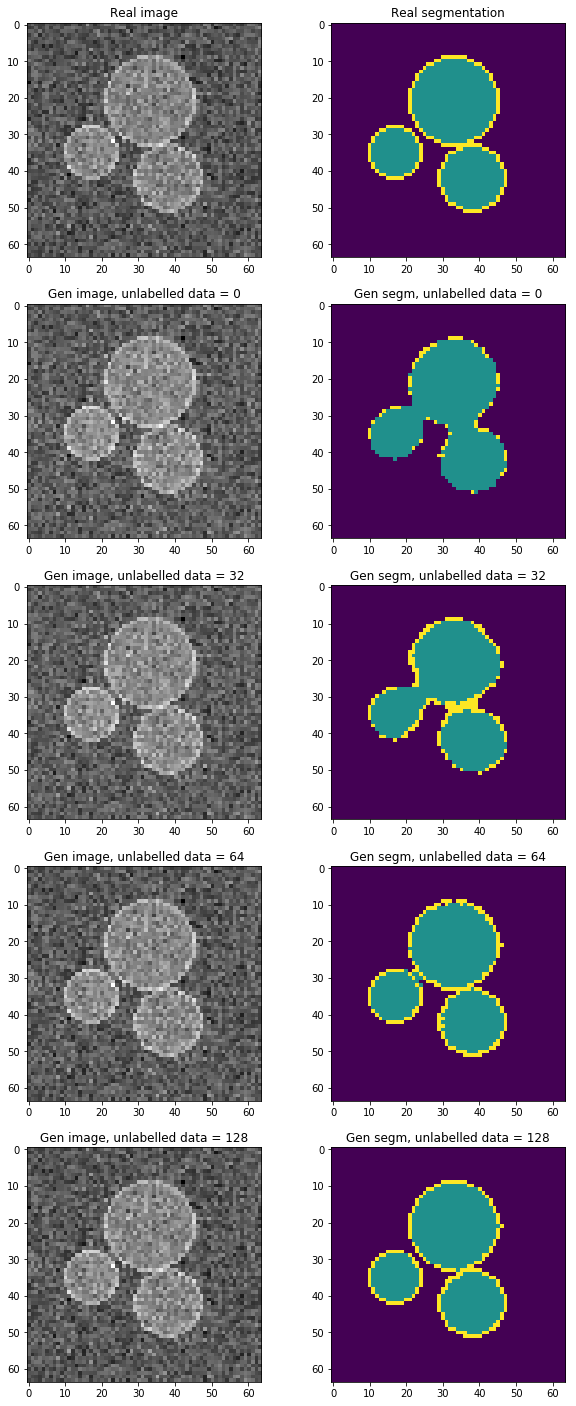

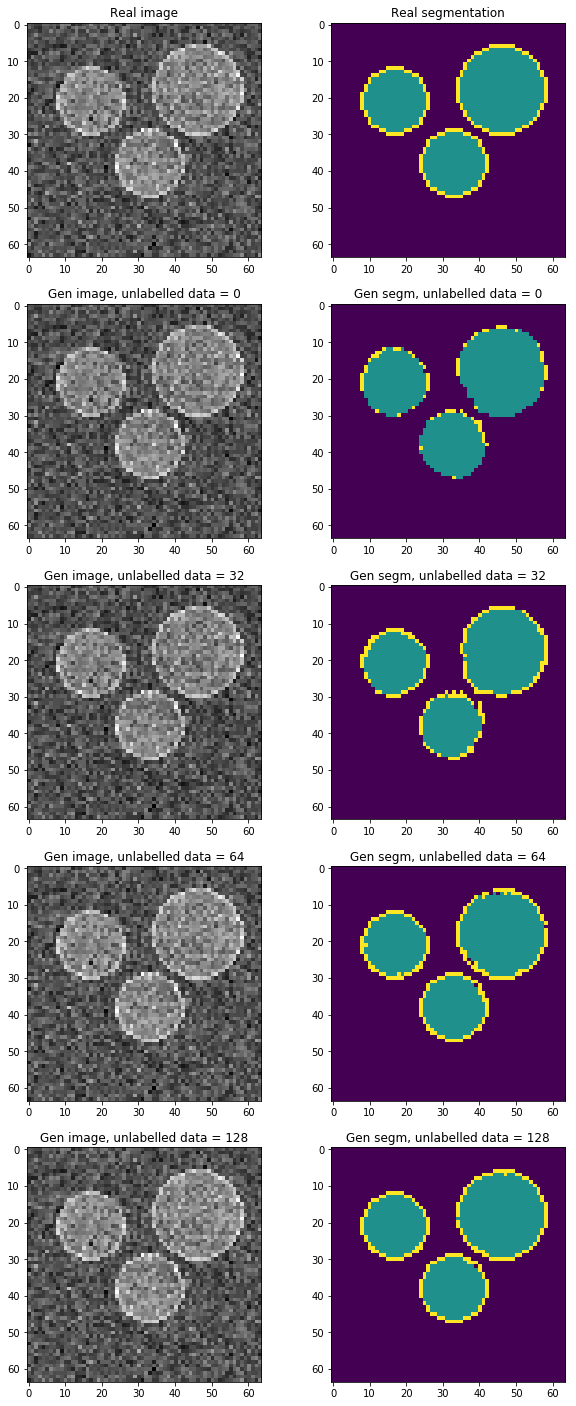

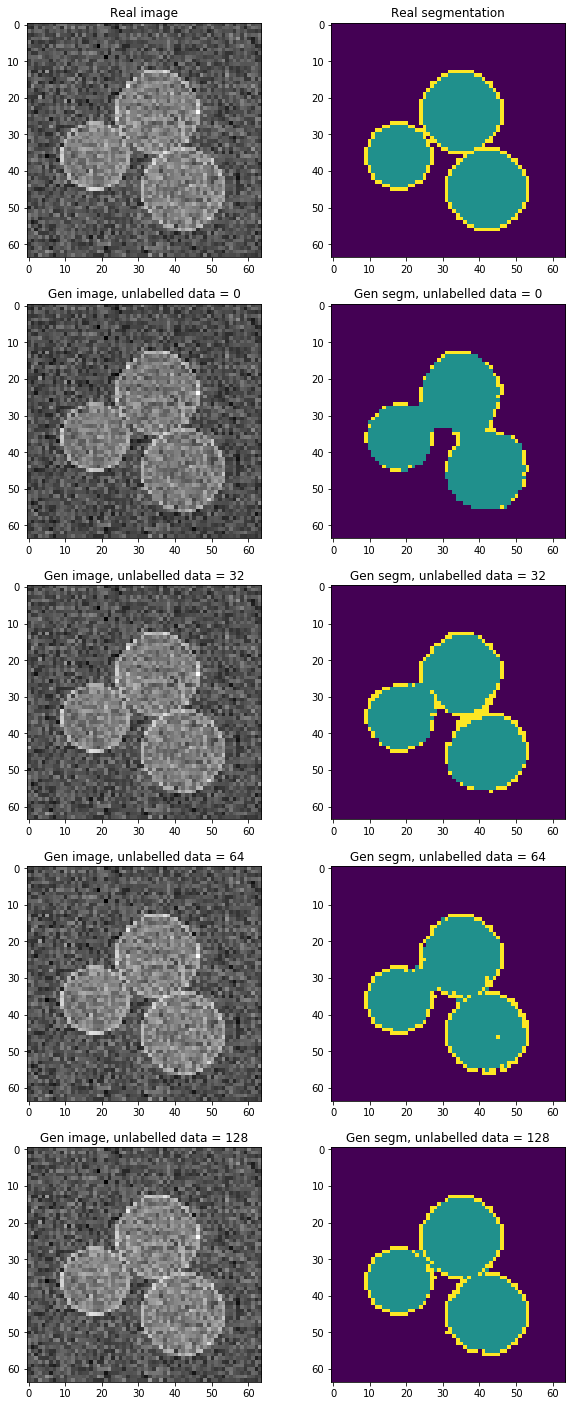

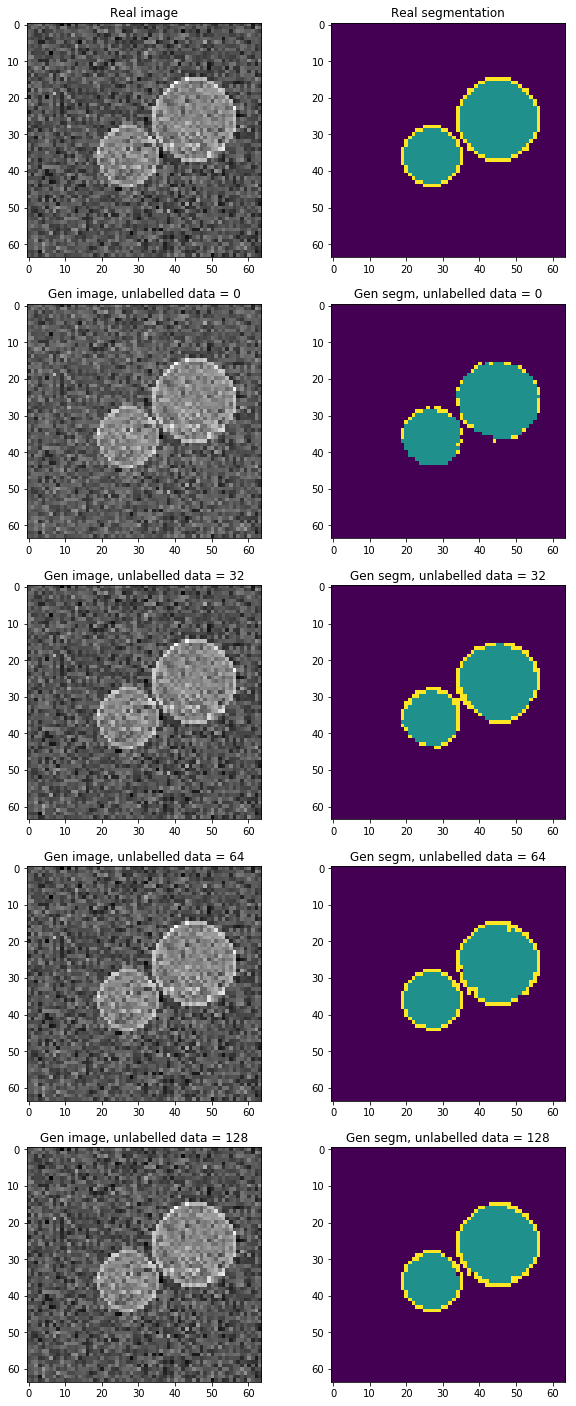

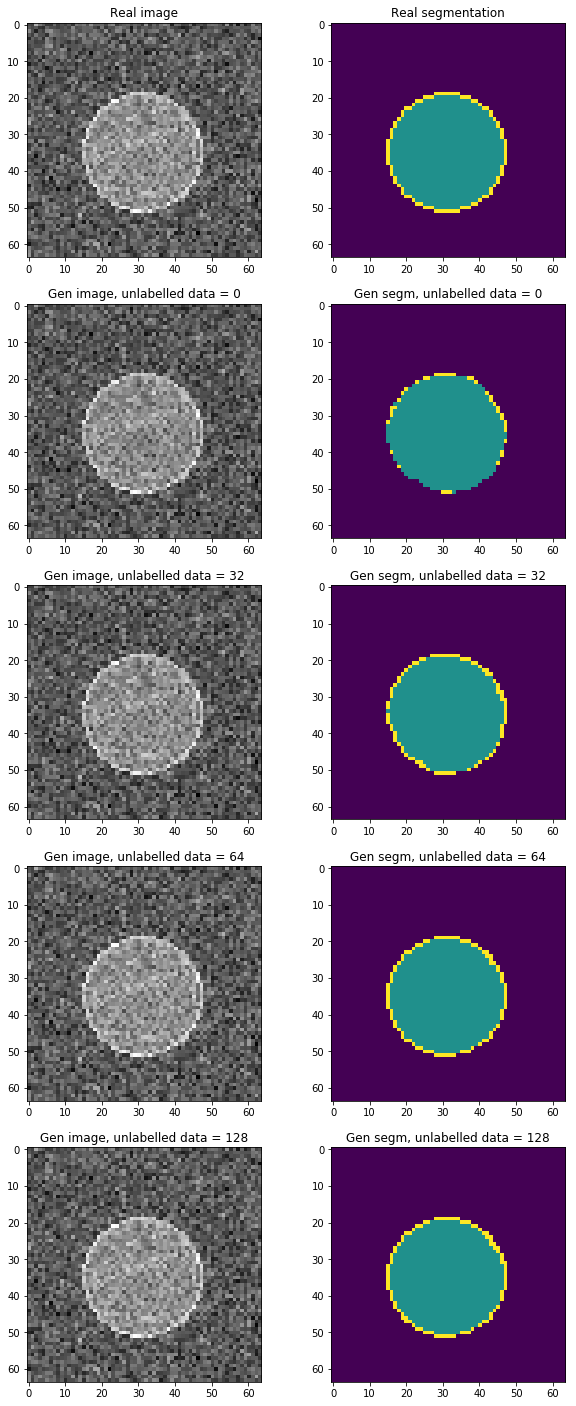

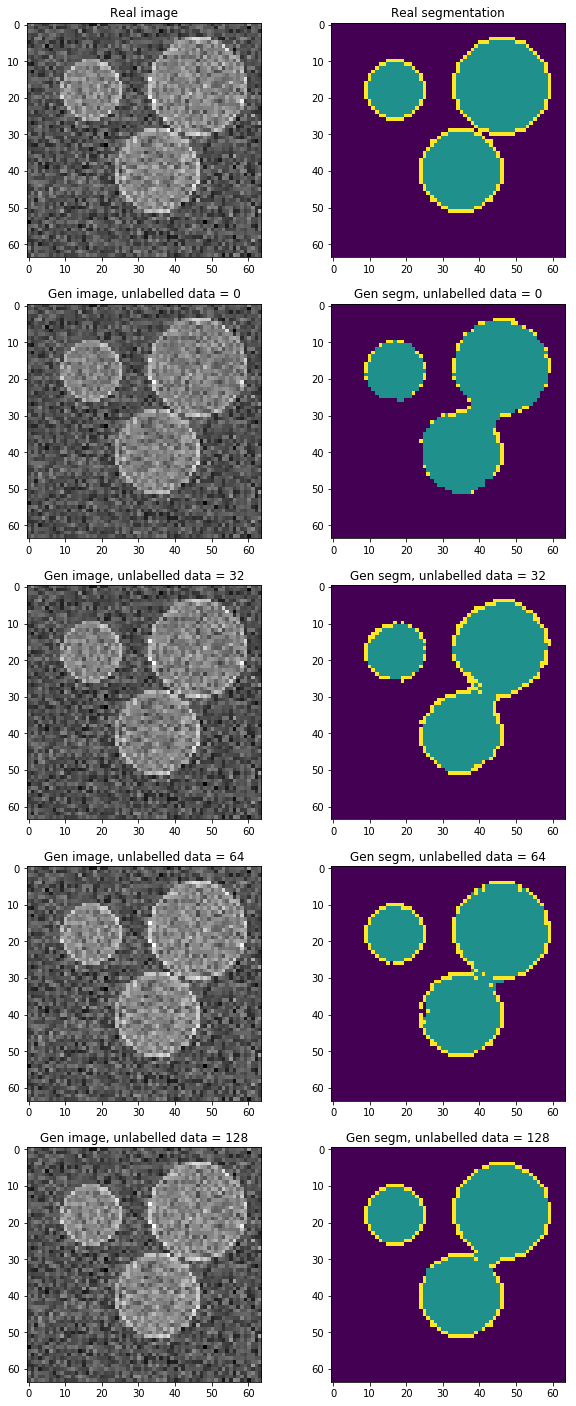

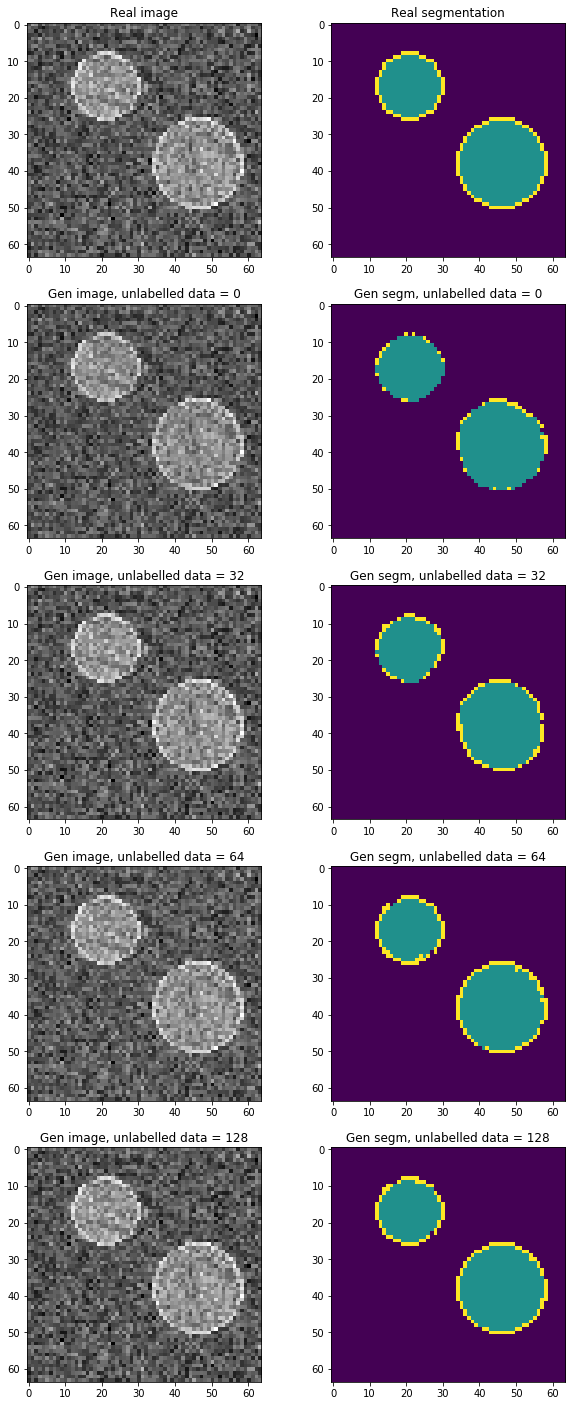

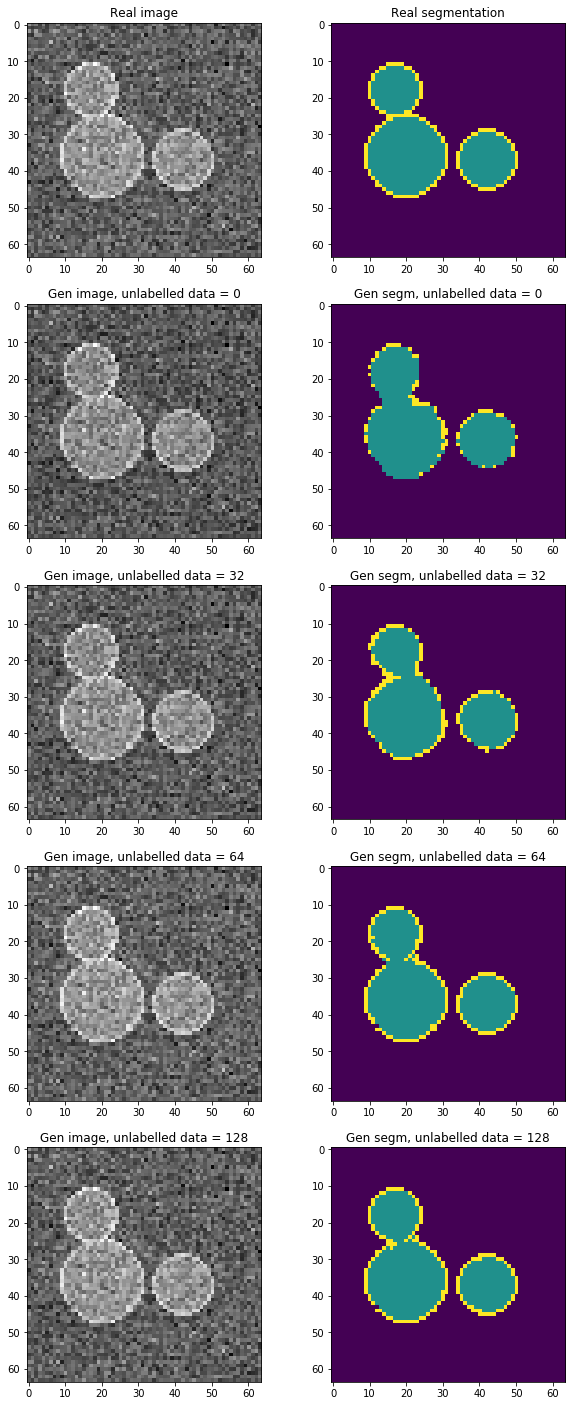

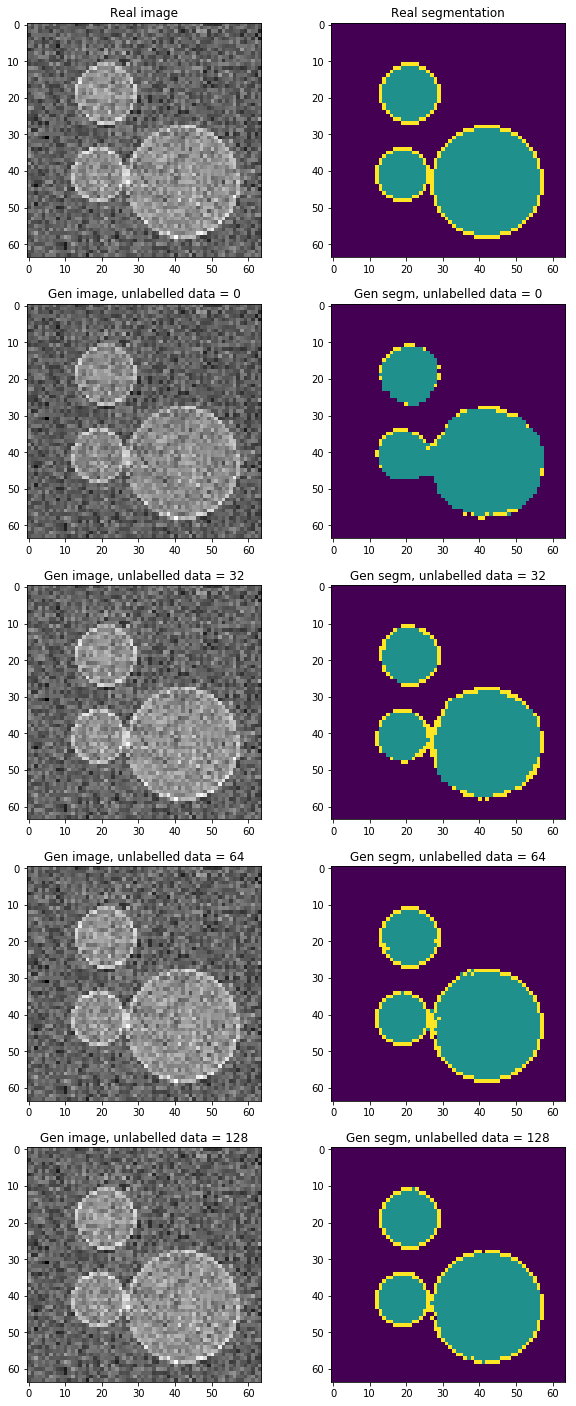

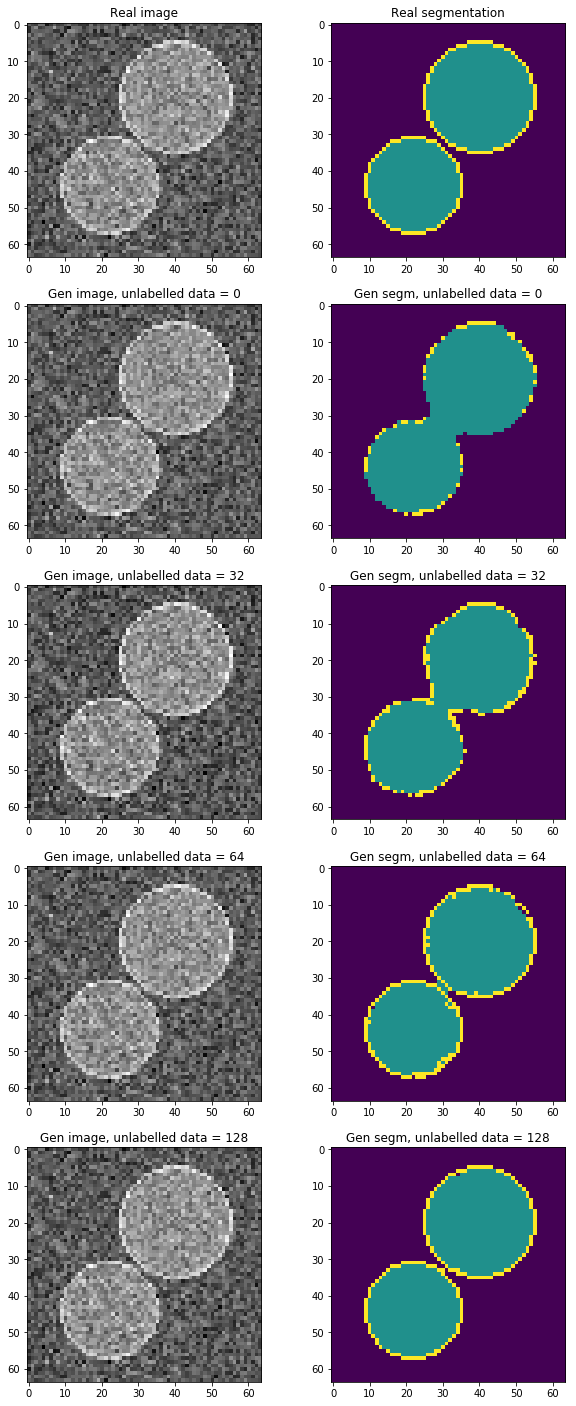

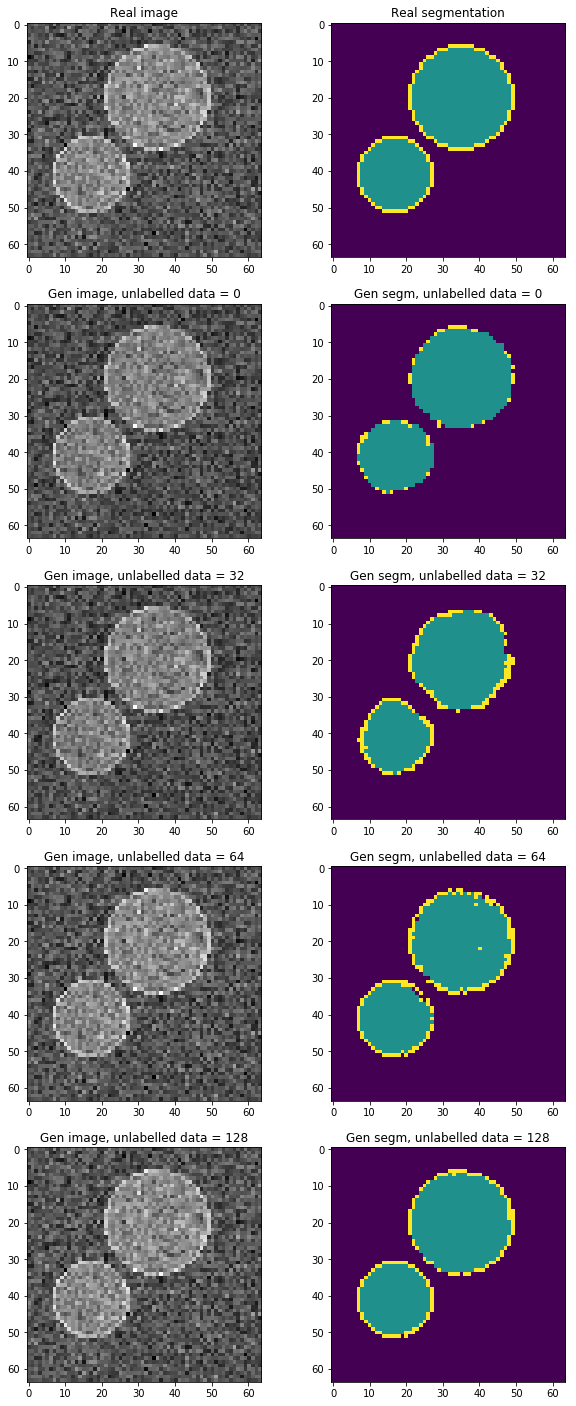

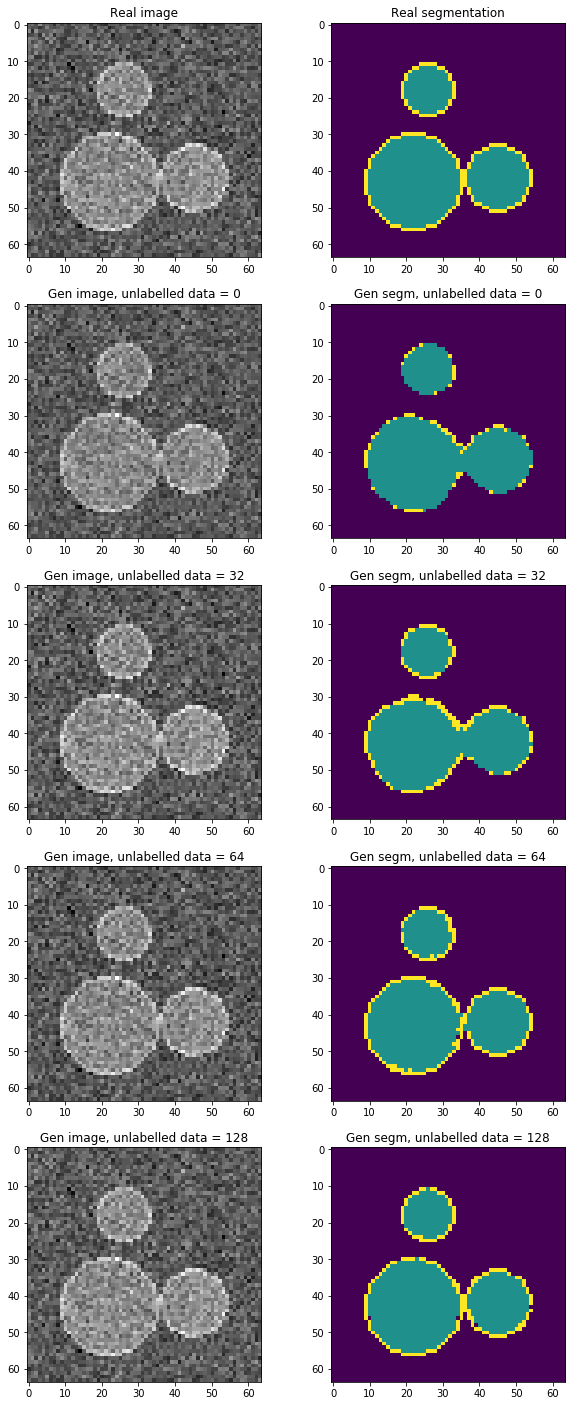

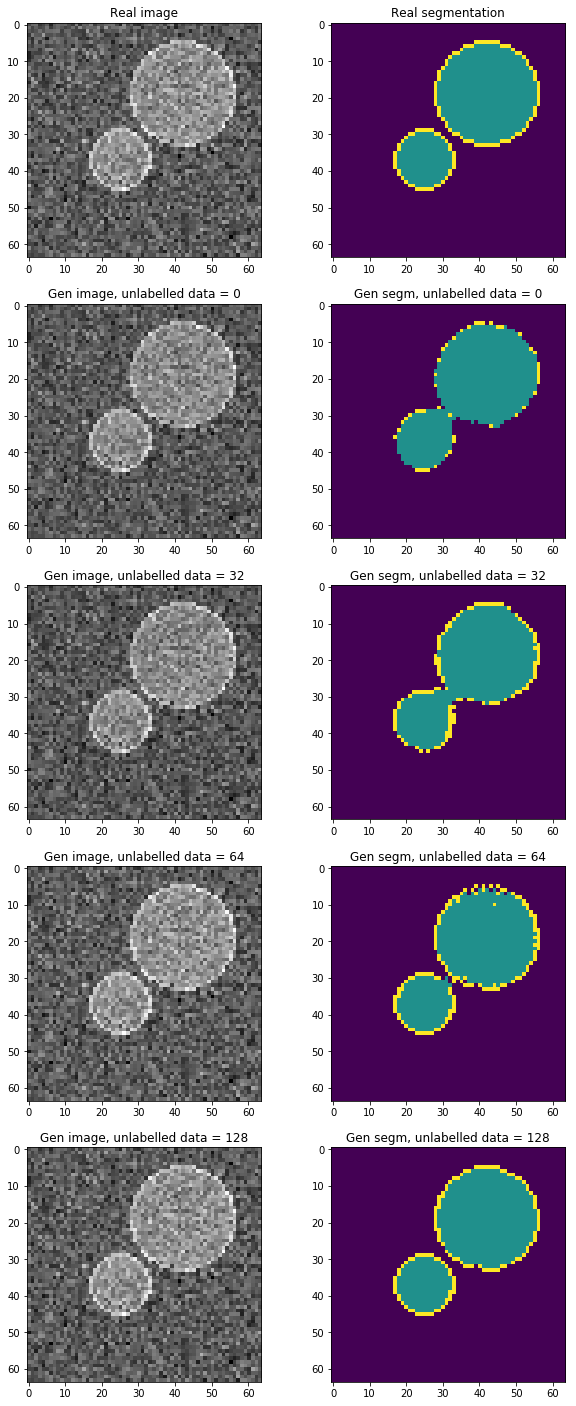

In [40]:
gt_images = data['test'][0].cpu().data.numpy()
gt_segms = data['test'][1].cpu().data.numpy()

for j, gt_image, gt_segm in zip(range(len(gt_images)), gt_images, gt_segms):
    f, axarr = plt.subplots(5, 2, figsize=(10, 25))
    
    axarr[0, 0].imshow(gt_image[0], cmap='gray')
    axarr[0, 0].set_title('Real image')
    
    axarr[0, 1].imshow(gt_segm)
    axarr[0, 1].set_title('Real segmentation')
    
    for i, num_unlabelled in enumerate([0, 32, 64, 128]):
        axarr[i + 1, 0].imshow(reconstruction_test[i][j][0], cmap='gray')
        axarr[i + 1, 0].set_title('Gen image, unlabelled data = {}'.format(num_unlabelled))
        axarr[i + 1, 1].imshow(np.argmax(segmentation_test[i][j], 0))
        axarr[i + 1, 1].set_title('Gen segm, unlabelled data = {}'.format(num_unlabelled))
plt.show()

### Experiments with real data

In [6]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
from torch.autograd import Variable
from PIL import Image
from PIL import ImageChops
from PIL import ImageEnhance
import torch.optim as optim
import tqdm
import copy

### Preprocess dataset

In [7]:
def process_dataset():
    file_names = sorted(glob.glob('./BBBC018/outlines/*'))
    file_numbers = []
    for file_name in file_names:
        number = file_name.split('/')[-1]
        number = number.split('-')[0]
        if number not in file_numbers:
            file_numbers.append(number)

    file_numbers_train = file_numbers[:45]
    file_numbers_val = file_numbers[45:50]
    file_numbers_test = file_numbers[50:]


    for file_name in sorted(glob.glob('./BBBC018/images/*')):
        image = imageio.imread(file_name)
        name = file_name.split('_')[-1]
        number = name.split('-')[0]
        type_img = name.split('-')[1][:3]
        if type_img == 'DNA':
            type_img = 'nuclei.png'
        elif type_img == 'act':
            type_img = 'cells.png'
        else:
            continue
        if number in file_numbers_train:
            imageio.imsave('./BBBC018_processed/images/train/{0}-{1}'.format(number, type_img), image)
        elif number in file_numbers_val:
            imageio.imsave('./BBBC018_processed/images/val/{0}-{1}'.format(number, type_img), image)
        else:
            imageio.imsave('./BBBC018_processed/images/test/{0}-{1}'.format(number, type_img), image)

    for file_name in sorted(glob.glob('./BBBC018/outlines/*')):
        segmentation = imageio.imread(file_name)
        name = file_name.split('/')[-1]
        number = name.split('-')[0]
        if number in file_numbers_train:
            imageio.imsave('./BBBC018_processed/segmentation/train/{0}'.format(name), segmentation)
        elif number in file_numbers_val:
            imageio.imsave('./BBBC018_processed/segmentation/val/{0}'.format(name), segmentation)
        else:
            imageio.imsave('./BBBC018_processed/segmentation/test/{0}'.format(name), segmentation)

In [8]:
im = imageio.imread('./BBBC018_processed/images/train/00733-cells.png')
mask = imageio.imread('./BBBC018_processed/segmentation/train/00733-cells.png')

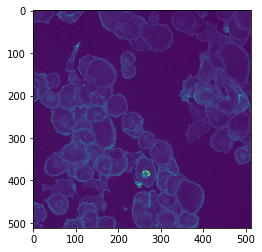

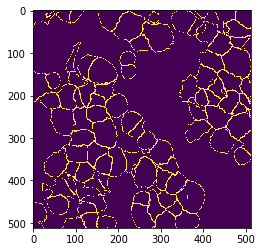

In [9]:
plt.imshow(im[:, :, 1])
plt.show()
plt.imshow(mask)
plt.show()

### Class for transformations of the dataset

In [10]:
class SegmentationTransform(object):
    def __init__(self, train_trainsforms=True):
        self.train_trainsforms = train_trainsforms
        #if train_trainsforms:
        #    self.color_jitter = transforms.ColorJitter(contrast=0.5)
        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize(size=(512, 512))
        
    def __call__(self, input_image, input_segmentation):
        
        image = transforms.ToPILImage()(input_image[:, :, 0].reshape(512, 512, 1))
        segmentation = transforms.ToPILImage()(input_segmentation.reshape(512, 512, 1))
        if self.train_trainsforms:
            if np.random.random() < 0.5:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
                segmentation = segmentation.transpose(Image.FLIP_TOP_BOTTOM)
            if np.random.random() < 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                segmentation = segmentation.transpose(Image.FLIP_LEFT_RIGHT)
            #image = self.color_jitter(image)
            
#             angle = np.random.randint(-20, 20)
#             image = image.rotate(angle)
#             segmentation = segmentation.rotate(angle)
#             offset = np.abs(int(512*np.tan(angle*np.pi/180)/2))
#             image = image.crop((offset, offset, image.size[0] - offset, image.size[1] - offset))
#             segmentation = segmentation.crop((offset, offset, segmentation.size[0] - offset, 
#                                               segmentation.size[1] - offset))
#             image = self.resize(image)
#             segmentation = self.resize(segmentation)
            
            enhancer = ImageEnhance.Contrast(image)
            
            factor = np.random.uniform(low=0.3, high=2.0)
            image = enhancer.enhance(factor)
            
            enhancer = ImageEnhance.Brightness(image)
            
            factor = np.random.uniform(low=0.3, high=2.0)
            image = enhancer.enhance(factor)
            
            x_offset = np.random.randint(0, 256)
            y_offset = np.random.randint(0, 256)
            
            image = image.crop((x_offset, y_offset, x_offset + 256, y_offset + 256))
            segmentation = segmentation.crop((x_offset, y_offset, x_offset + 256, y_offset + 256))
            
        
        image_tensor = self.to_tensor(image)
        segmentation = np.array(segmentation)
        segmentation_tensor = np.zeros_like(segmentation)
        segmentation_tensor[segmentation != 0] = 1
#         plt.figure(figsize=(10,8))
#         plt.subplot(1,2,1)
#         plt.imshow(np.array(image), 'gray')
#         plt.subplot(1,2,2)
#         plt.imshow(segmentation_tensor, 'gray')
#         plt.show()
        segmentation_tensor = torch.LongTensor(segmentation_tensor)
        return image_tensor, segmentation_tensor
        #plt.imshow(np.array(image))
        #plt.imshow(np.array(segmentation), 'gray')

In [11]:
transf = SegmentationTransform()
_ = transf(im, mask)

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, path_to_img, path_to_segmentation, transforms=None):
        if transforms:
            self.transforms = transforms
        else:
            self.transforms = None
        self.idx_to_files = {i: file_name.split('/')[-1]
                             for i, file_name in enumerate(sorted(glob.glob(path_to_img + '*')))}
        self.path_to_img = path_to_img
        self.path_to_segmentation = path_to_segmentation

    
    def __len__(self):
        return len(self.idx_to_files)
    
    def __getitem__(self, idx):
        image_name = self.path_to_img + self.idx_to_files[idx]
        segmentation_name = self.path_to_segmentation + self.idx_to_files[idx]
        im = imageio.imread(image_name)
        mask = imageio.imread(segmentation_name)
        if self.transforms:
            im, mask = self.transforms(im, mask)
        return im, mask

In [13]:
def train_on_real_data(data_loader_train, data_loader_val, net, number_with_segmentation, 
                       num_epoch, img_loss, segm_loss, num_in_batch):
    train_loss_history = []
    val_loss_history = []
    
    last_update = 0
    best_val_score = None
    best_model_params = None
    
    optimizer = optim.Adam(net.parameters())
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        
        net.train(True)
        
        i = 0 
        
        for image_batch, segmentation_batch in data_loader_train:
            
            optimizer.zero_grad()
            image_batch = Variable(image_batch[:num_in_batch], requires_grad=False).cuda(1)
            segmentation_batch = Variable(segmentation_batch[:number_with_segmentation], 
                                          requires_grad=False).cuda(1)
            
            generated_images, generated_segmentation = net.forward(image_batch)

            train_loss = segm_loss(generated_segmentation[:number_with_segmentation], segmentation_batch)

            train_loss += 1000*img_loss(generated_images, image_batch)
            if i == 0:
                train_loss_history.append(train_loss.data[0])
                
            else:
                train_loss_history[-1] += train_loss.data[0]
            
            i += 1

            train_loss.backward()
            optimizer.step()
            
        train_loss_history[-1] /= i

        net.train(False)
        
        i = 0
        
        for image_batch, segmentation_batch in data_loader_val:
            image_batch = Variable(image_batch, requires_grad=False).cuda(1)
            segmentation_batch = Variable(segmentation_batch, requires_grad=False).cuda(1)
            generated_val_images, generated_val_segmentation = net.forward(image_batch)
            val_loss = segm_loss(generated_val_segmentation, segmentation_batch)
            val_loss += 1000*img_loss(generated_val_images, image_batch)
            if i == 0:
                val_loss_history.append(val_loss.data[0])
            else:
                val_loss_history[-1] += val_loss.data[0]
            i += 1
        
        val_loss_history[-1] /= i

        if best_val_score is None or best_val_score > val_loss_history[-1]:
            best_val_score = val_loss_history[-1]
            best_model_params = copy.deepcopy(net.state_dict())
            last_update = 0
        else:
            last_update += 1

        
    return train_loss_history, val_loss_history, best_model_params

In [14]:
segmentation_dataset_train = SegmentationDataset(path_to_img='./BBBC018_processed/images/train/', 
                                                 path_to_segmentation='./BBBC018_processed/segmentation/train/', 
                                                 transforms=SegmentationTransform())
data_loader_train = DataLoader(segmentation_dataset_train, batch_size=9, shuffle=False, num_workers=1)

segmentation_dataset_validation = SegmentationDataset(path_to_img='./BBBC018_processed/images/val/', 
                                                      path_to_segmentation='./BBBC018_processed/segmentation/val/', 
                                                      transforms=SegmentationTransform(False))
data_loader_val = DataLoader(segmentation_dataset_validation, batch_size=1, shuffle=False, num_workers=1)

segmentation_dataset_test = SegmentationDataset(path_to_img='./BBBC018_processed/images/test/', 
                                                path_to_segmentation='./BBBC018_processed/segmentation/test/', 
                                                transforms=SegmentationTransform(False))
data_loader_test = DataLoader(segmentation_dataset_test, batch_size=1, shuffle=False, num_workers=1)

In [15]:
net = ImageSegmentationImageModel(input_dim=1, num_classes=2, batch_norm=True).cuda(1)
starting_parameters = copy.deepcopy(net.state_dict())
segm_loss = SegmentationLoss(weight=torch.FloatTensor(np.array([1.0, 5.0])).cuda(1))
img_loss = ImageLoss()

All unlabelled images:

In [27]:
train_loss = np.load('80_model_train_loss.npy')
val_loss = np.load('80_model_val_loss.npy')
net.load_state_dict(torch.load('80_model'))

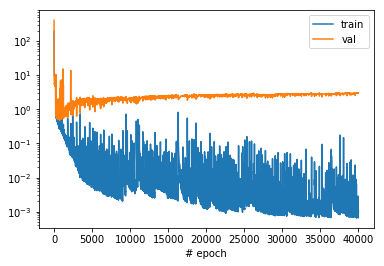

In [28]:
plt.semilogy(train_loss, label='train')
plt.semilogy(val_loss, label='val')
plt.legend()
plt.xlabel('# epoch')
plt.show()

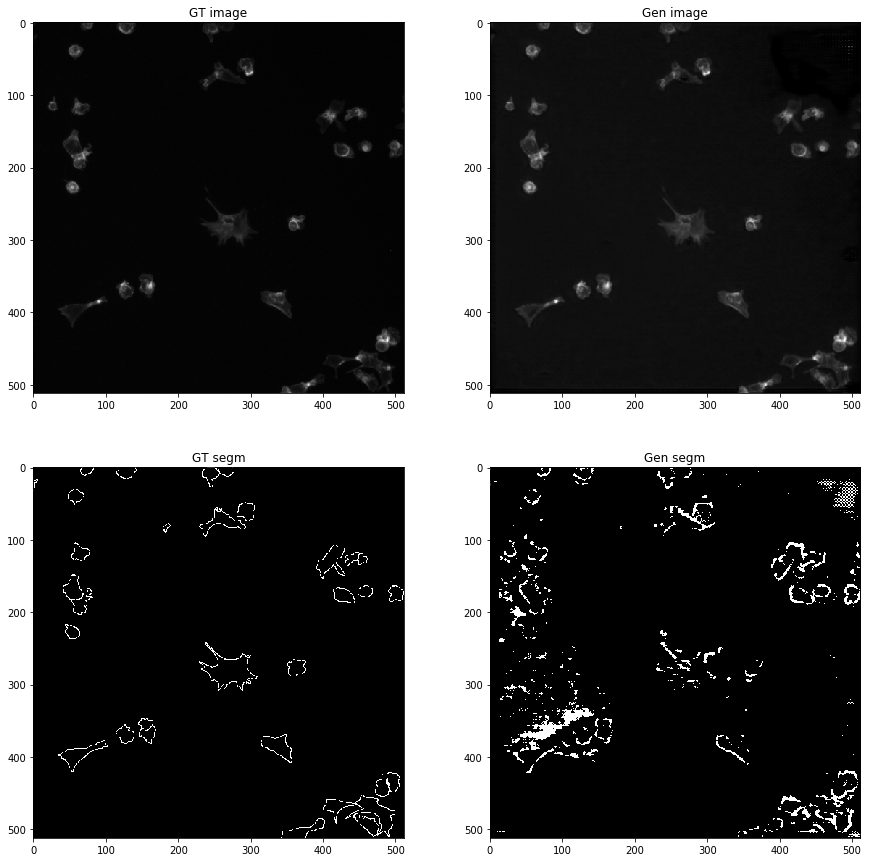

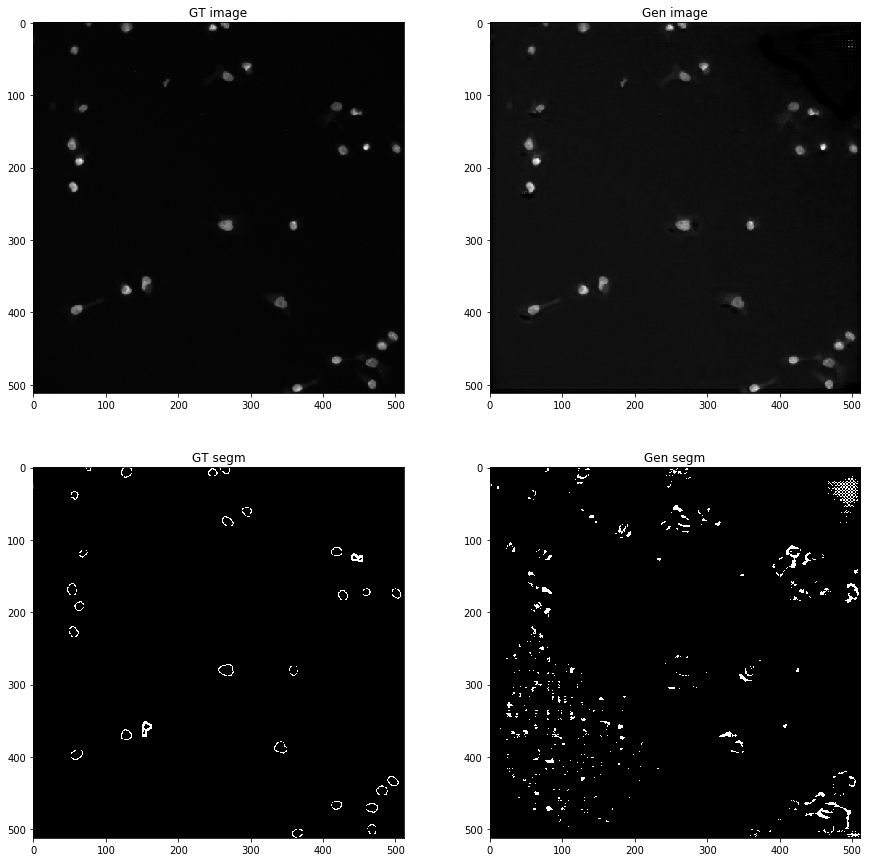

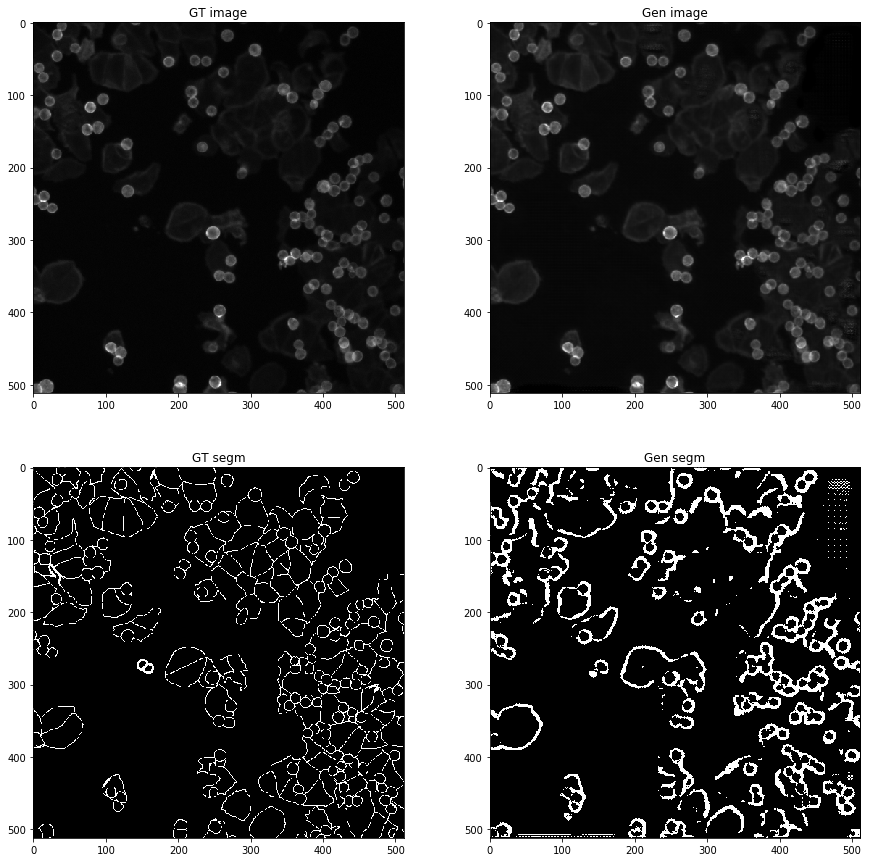

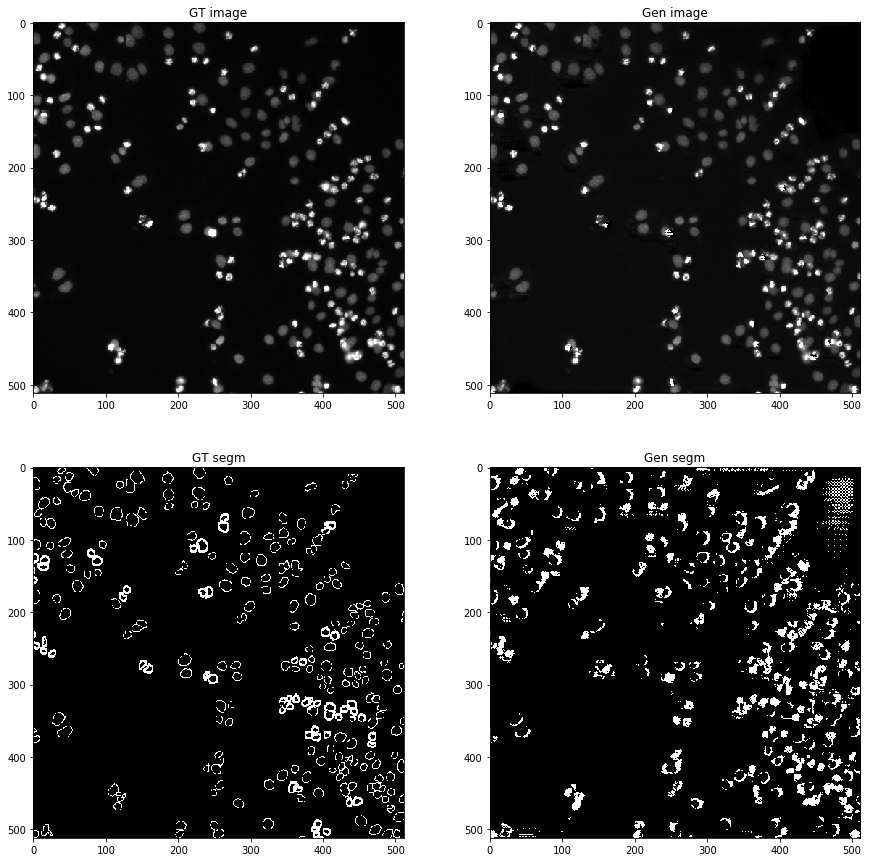

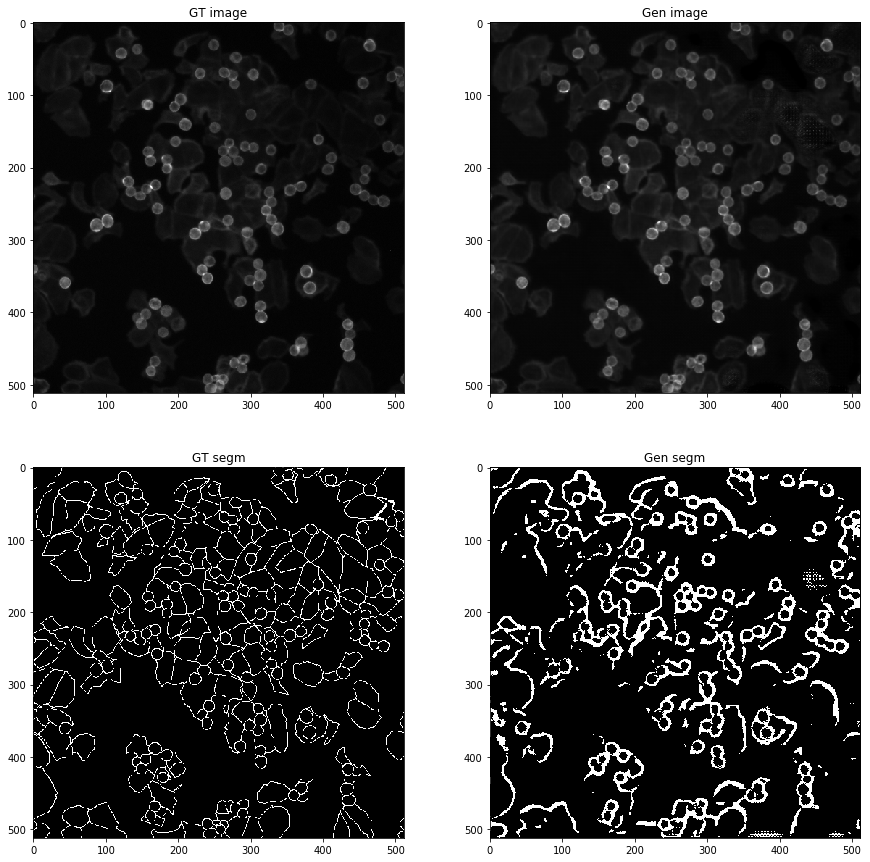

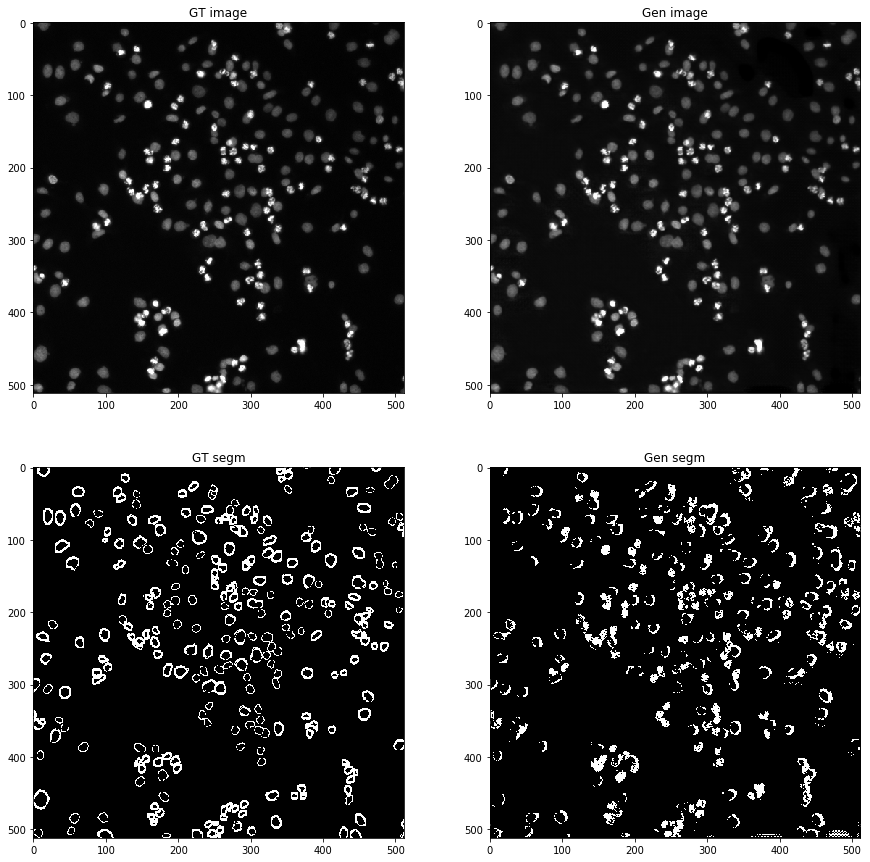

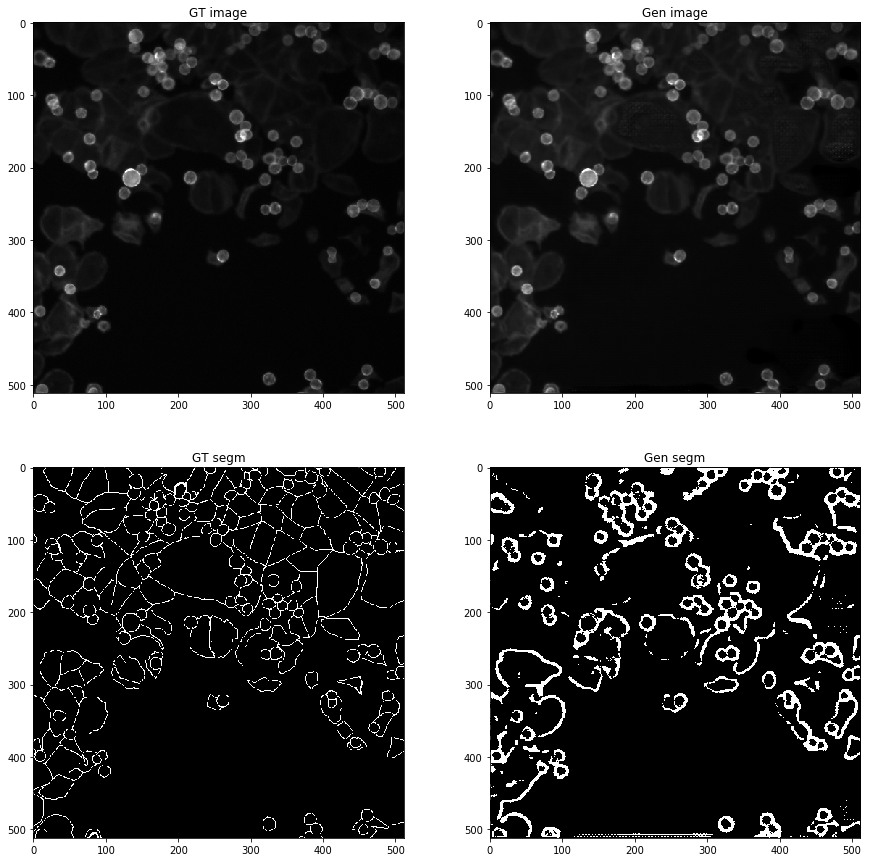

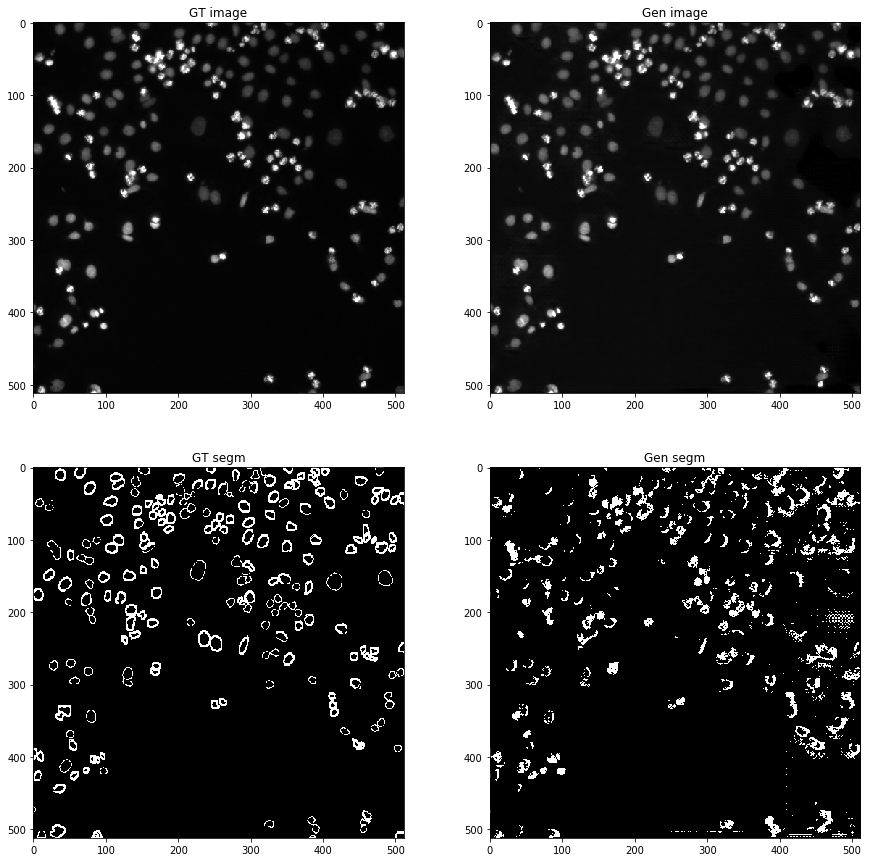

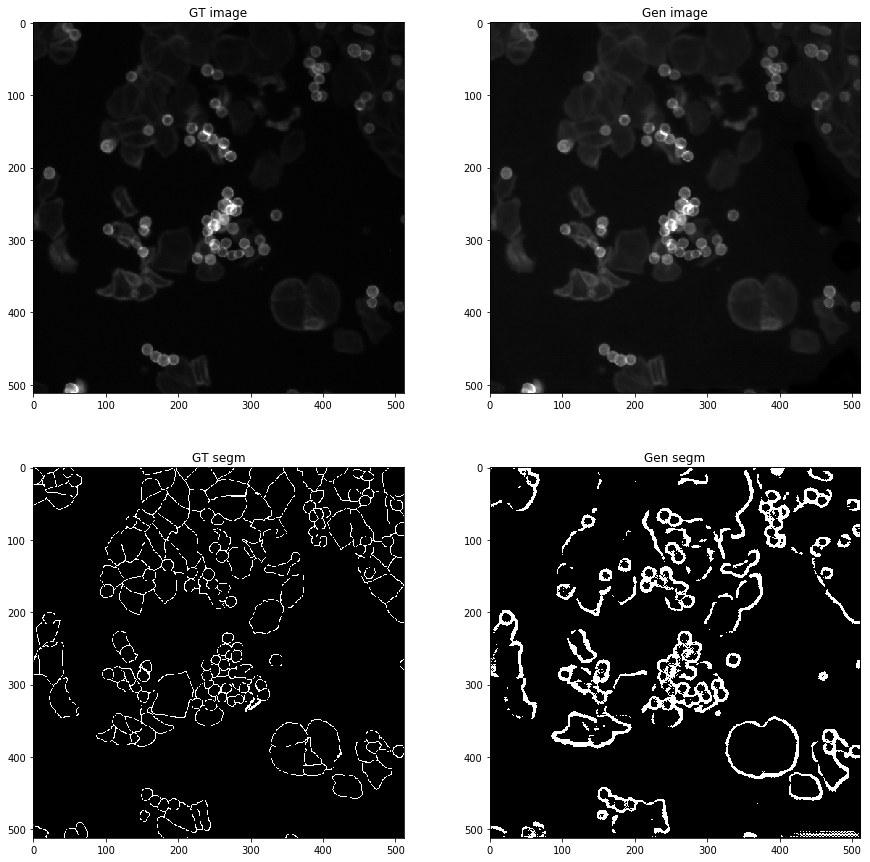

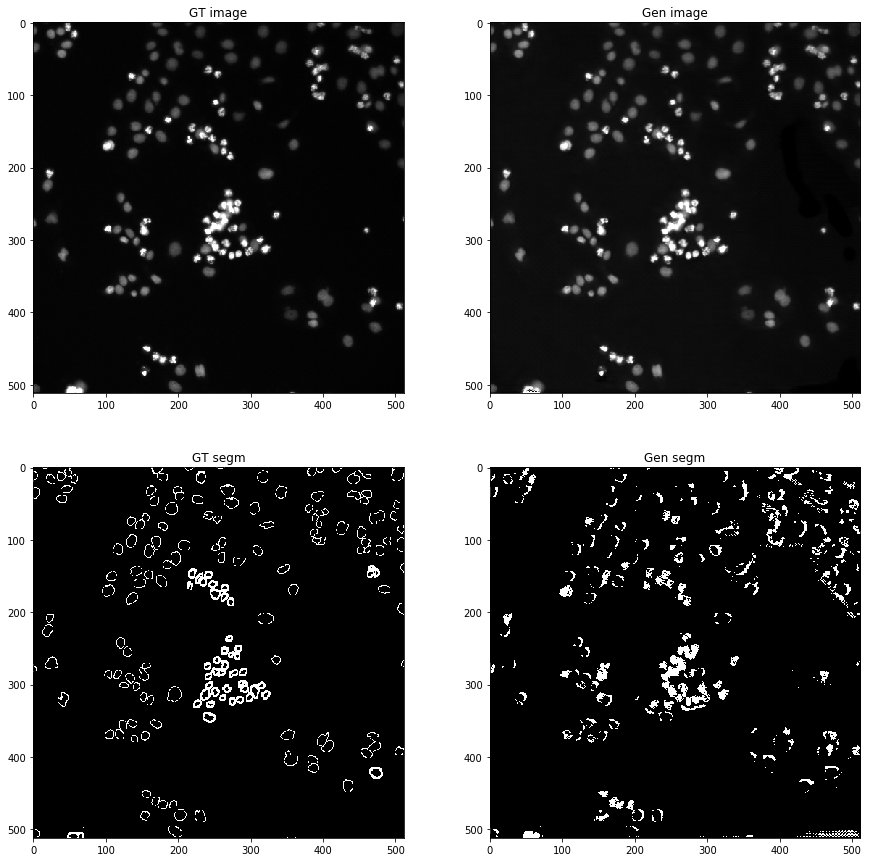

In [29]:
for image, segmentation in data_loader_test:
    image = Variable(image, requires_grad=False).cuda(1)
    generated_image, generated_segmentation = net.forward(image)
    f, ax = plt.subplots(2, 2, figsize=(15, 15))
    ax[0, 0].imshow(image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 0].set_title('GT image')
    ax[0, 1].imshow(generated_image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 1].set_title('Gen image')
    ax[1, 0].imshow(segmentation.numpy()[0], cmap='gray')
    ax[1, 0].set_title('GT segm')
    ax[1, 1].imshow(np.argmax(generated_segmentation.cpu().data.numpy()[0], axis=0), cmap='gray')
    ax[1, 1].set_title('Gen segm')
    

In [16]:
train_loss = np.load('10_model_train_loss.npy')
val_loss = np.load('10_model_val_loss.npy')
net.load_state_dict(torch.load('10_model'))

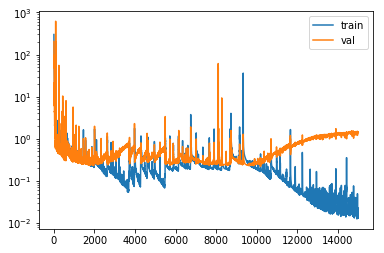

In [19]:
plt.semilogy(train_loss, label='train')
plt.semilogy(val_loss, label='val')
plt.legend()
plt.show()

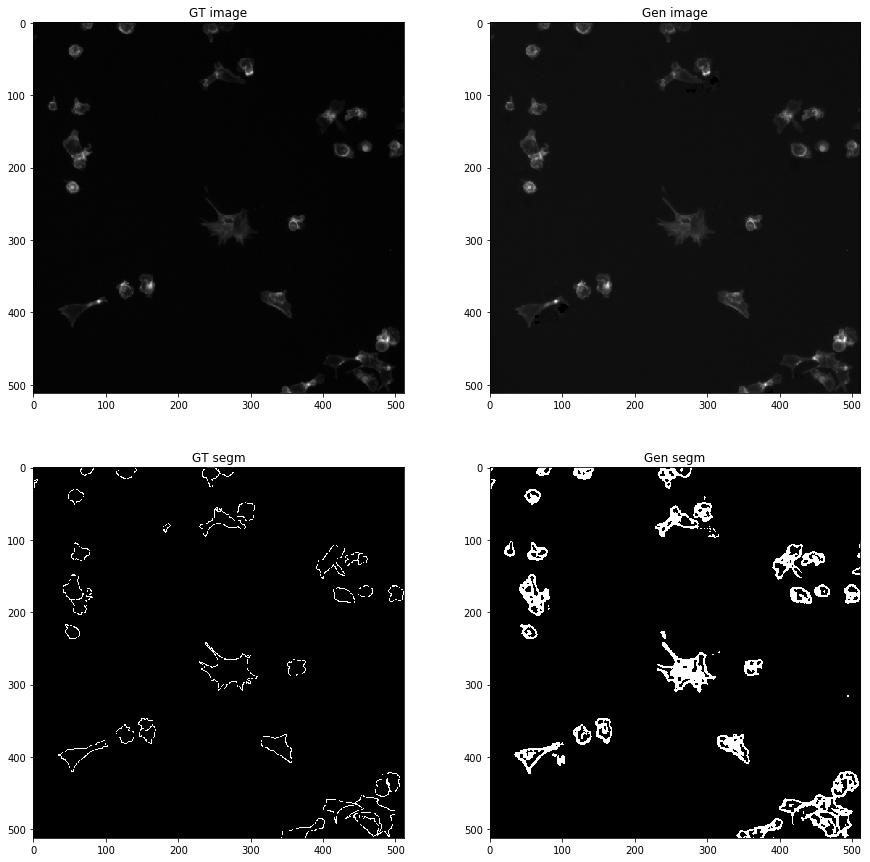

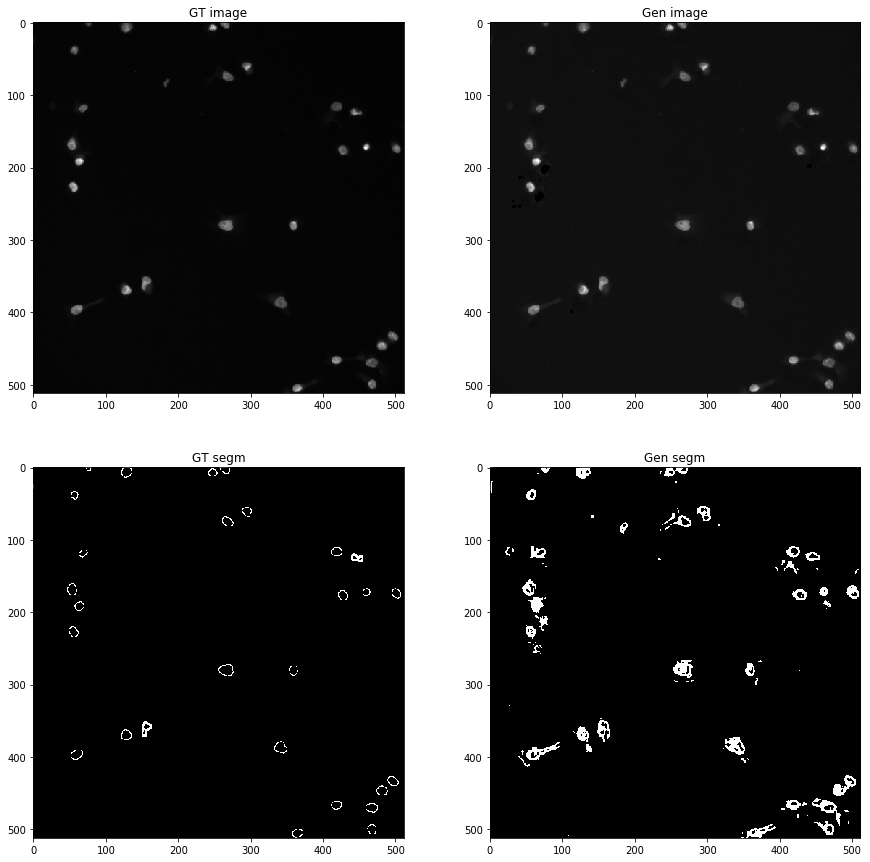

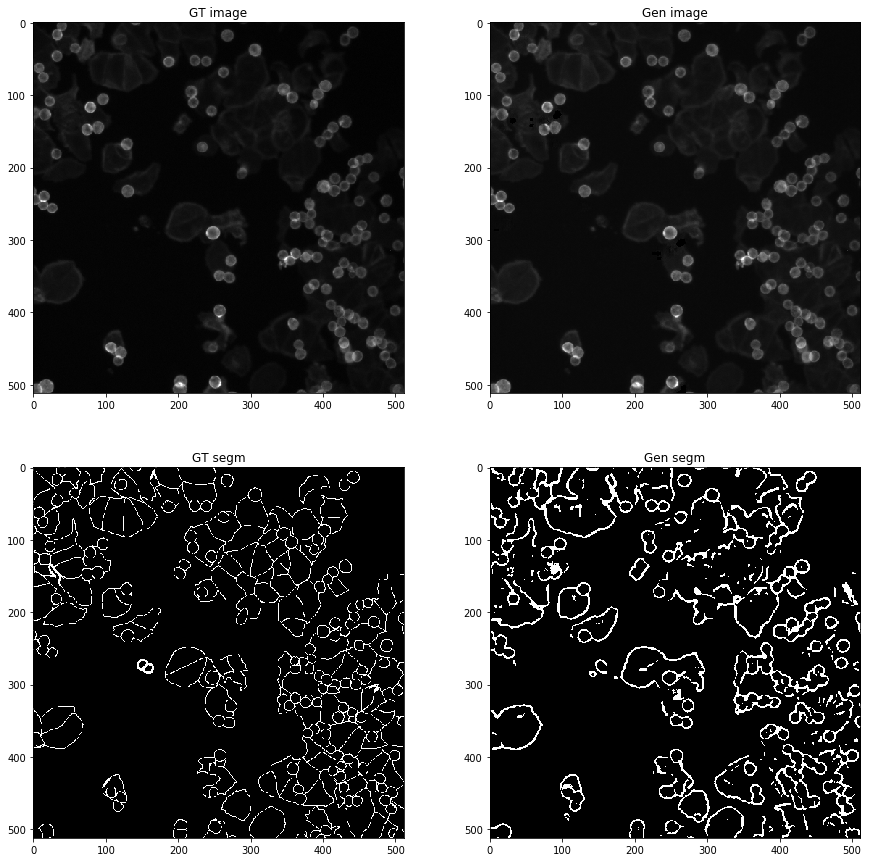

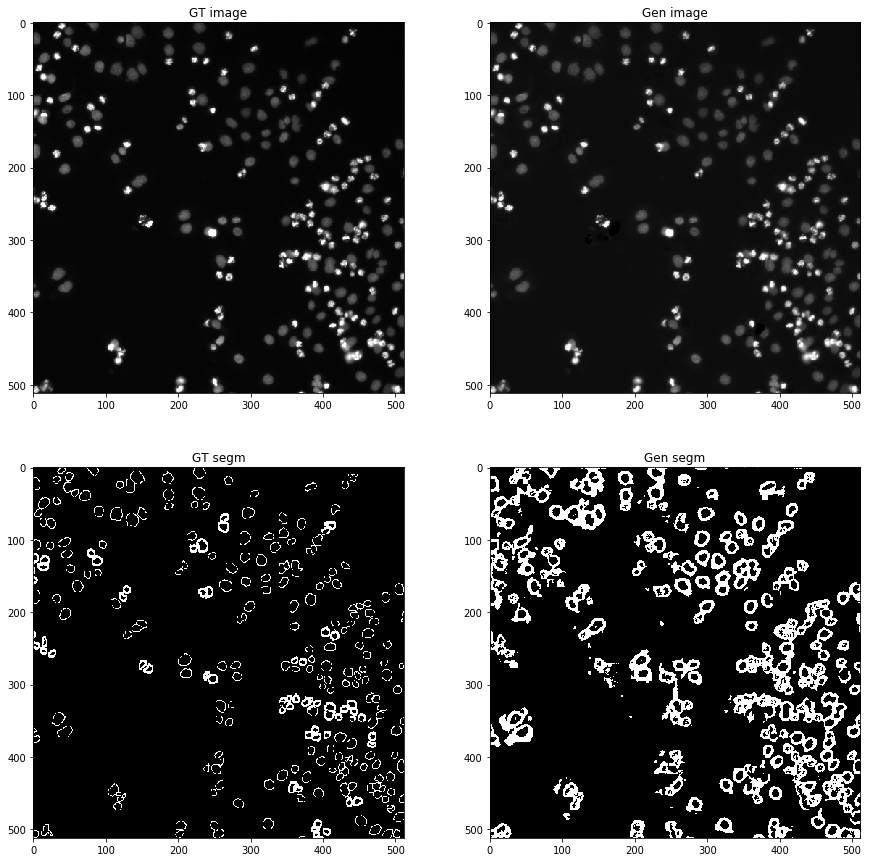

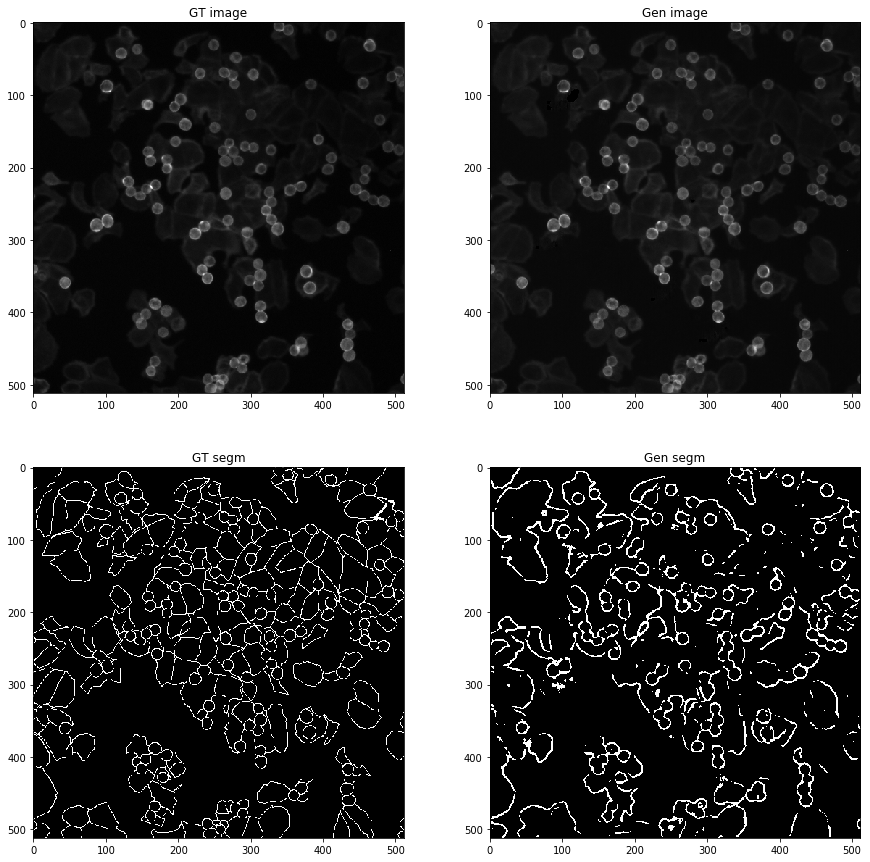

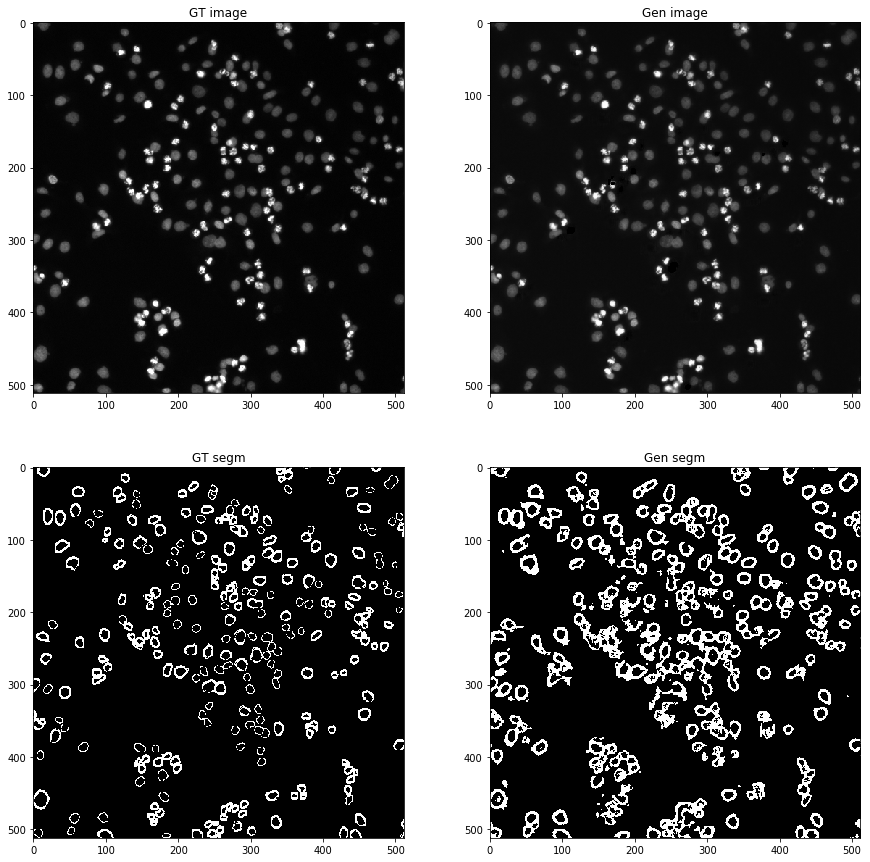

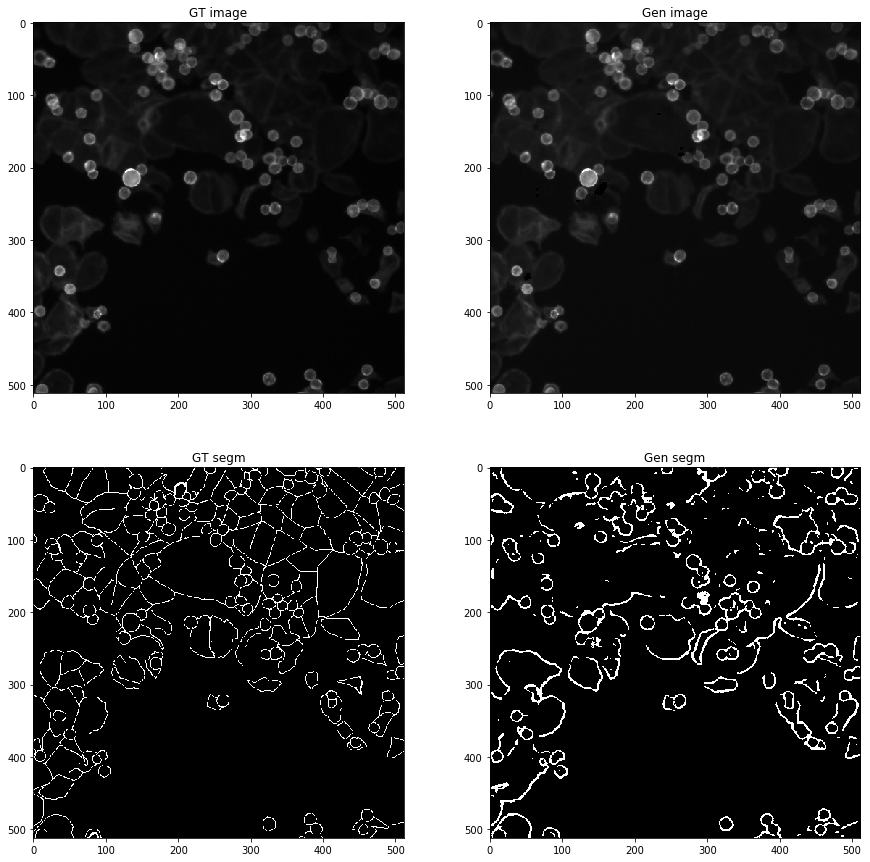

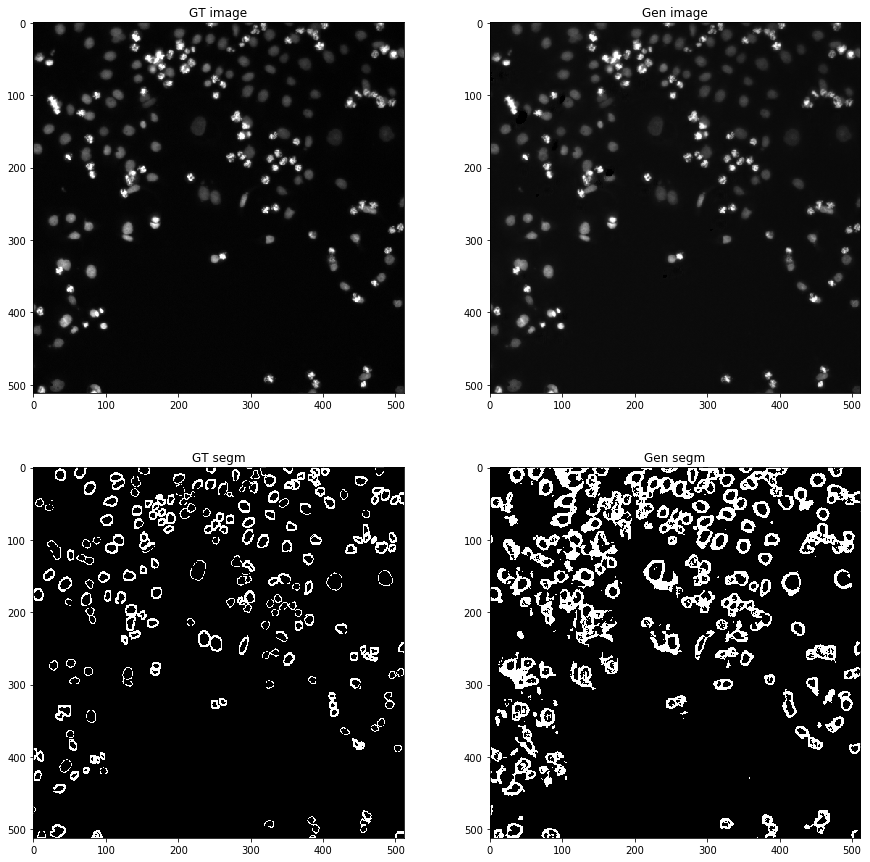

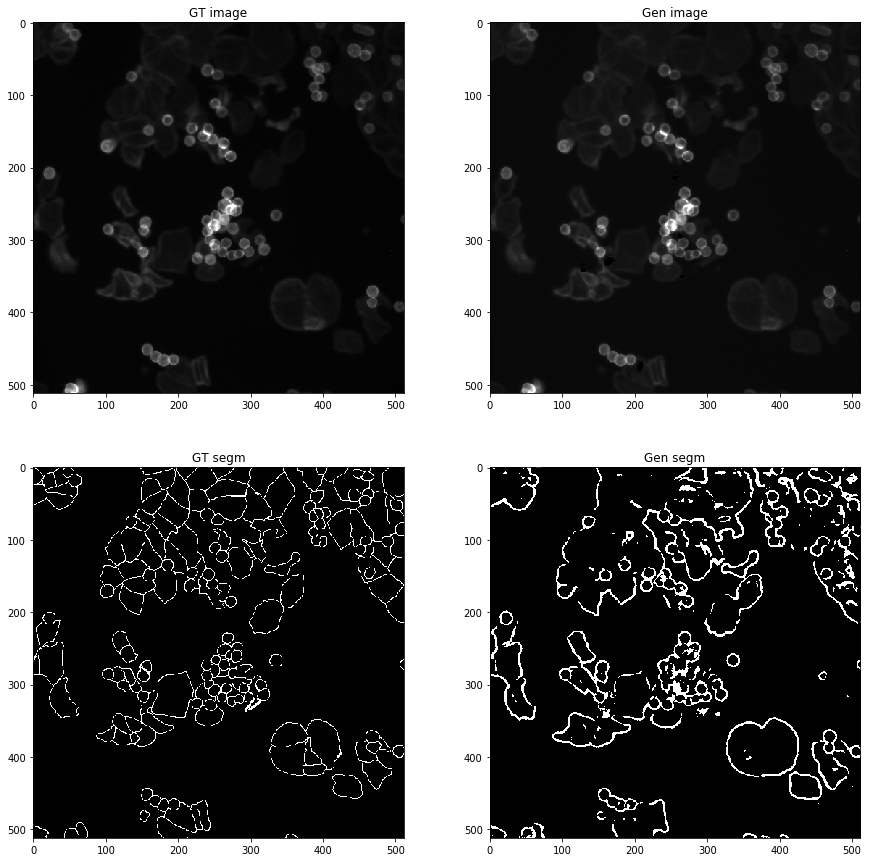

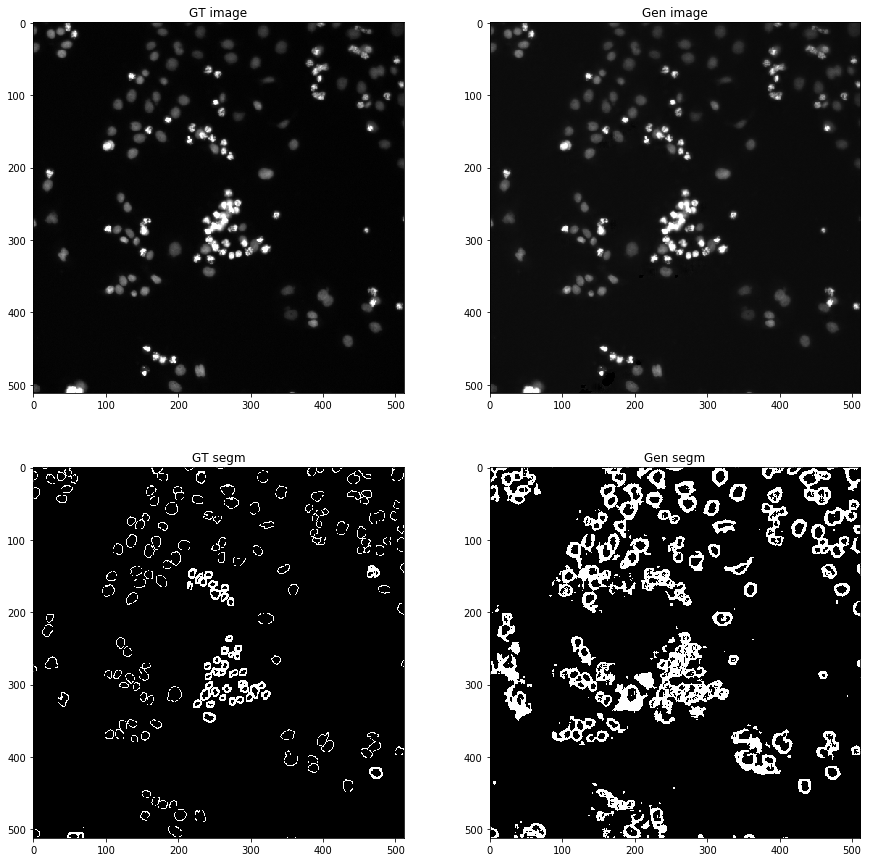

In [20]:
for image, segmentation in data_loader_test:
    image = Variable(image, requires_grad=False).cuda(1)
    generated_image, generated_segmentation = net.forward(image)
    f, ax = plt.subplots(2, 2, figsize=(15, 15))
    ax[0, 0].imshow(image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 0].set_title('GT image')
    ax[0, 1].imshow(generated_image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 1].set_title('Gen image')
    ax[1, 0].imshow(segmentation.numpy()[0], cmap='gray')
    ax[1, 0].set_title('GT segm')
    ax[1, 1].imshow(np.argmax(generated_segmentation.cpu().data.numpy()[0], axis=0), cmap='gray')
    ax[1, 1].set_title('Gen segm')
